###LEGO BRICK Clssifier

#### Import Libraries

In [9]:
import argparse
import itertools
#matplotlib.use("Agg")
import matplotlib
import numpy as np
import os
import tensorflow as tf
from skimage import data
from skimage import transform
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from keras.callbacks import ModelCheckpoint
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator


#### Load_Data

In [10]:
EPOCHS = 2
BS = 16
ap = argparse.ArgumentParser()
lego_classes = ["Brick corner", "Brick 2x2", "Brick 1x2", "Brick 1x1", "Plate 2x2", "Plate 1x2", "Plate 1x1",
                "Roof Tile", "Flat Tile 1x2", "Peg 2M",
                "Bush for Cross Axle", "Plate 1X2 with 1 Knob", "Technic Lever", "Bush 3M with Cross axle",
                "Cross Axle 2M", "half Bush"]

In [12]:
def load_data(data_dir):
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) 
                      if f.endswith(".png")]
        for f in file_names:
            images.append(data.imread(f))
            labels.append(int(d))
    return images, labels
ROOT_PATH = "C:/Users/Phoenix Aiden/Documents/"
train_data_dir = os.path.join(ROOT_PATH, "LEGO/train")
test_data_dir = os.path.join(ROOT_PATH, "LEGO/valid")
images, labels = load_data(train_data_dir)

#### Visualize Data 

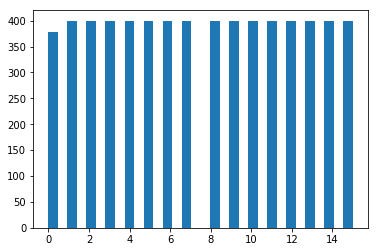

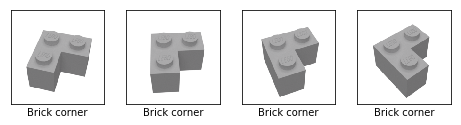

In [13]:
# Make a histogram with 32 bins of 16 labels.
plt.hist(labels, 32)
plt.show()
plt.figure(figsize=(10,10))
legos=[300, 2250, 3650, 4000]
for i in range(len(legos)):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.binary)
    plt.xlabel(lego_classes[labels[i]])
plt.show()

#### Normalize Images 

In [14]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(images, dtype="float") / 255.0
labels = np.array(labels)
#images64 = rgb2gray(np.array(images)) #Convert to Gray Scale for better perfomance

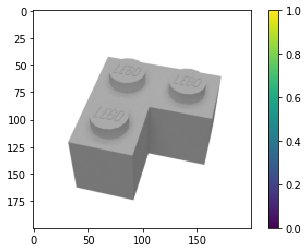

In [15]:
# Check to see if normalized (from 0 -> 255 to 0 -> 1)

plt.figure()
plt.imshow(data[0])
plt.colorbar()
plt.grid(False)
plt.show()

#### Split Data into Train and Test sets 

In [16]:
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.25, random_state=42)#Only Used the dataset marked 'Train' my pc has low amounts of RAM

#### Define Model 

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation=tf.nn.relu, input_shape=(200, 200, 4)),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,  activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128,  activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(16, activation=tf.nn.softmax)])

model.summary()  # Take a look at the model summary

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 64)      1088      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 100, 100, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)  

In [18]:
# Compile Model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
#checkpoint = ModelCheckpoint(filepath='model.hdf5', verbose=1, save_best_only=True)

# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
	horizontal_flip=True, fill_mode="nearest")

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor='val_loss',
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1)
]

#### Train Model and Save 

In [ ]:
H = model.fit_generator(
    aug.flow(trainX, trainY, batch_size=16),
    steps_per_epoch=(len(trainX) / 16),
    validation_data=[testX, testY],
    validation_steps=100,
    epochs=EPOCHS,
    verbose=1,
    callbacks=callbacks
)
# save the model to disk
print("[INFO] serializing network...")
model.save(args["model"])

#### Plot Loss and Accuracy 

In [ ]:
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Lego Bricks")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])

#### Evaluate Model and print ROC

In [ ]:
# Evaluate the model on test set
score = model.evaluate(testX, testY, verbose=0)
# Print test accuracy
print('\n', 'Test accuracy:', score[1])

